In [ ]:

import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm # Colormaps
from PIL import Image
import os
import torchvision
import torch
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import math
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from time import time
import cv2
from sklearn.metrics.pairwise import euclidean_distances

# source_dirs =['/content/drive/MyDrive/Bachelor/2020']
train_dir = '/content/drive/MyDrive/Bachelor/train_18_20'
val_dir = '/content/drive/MyDrive/Bachelor/val_18_20'

frm_df = pd.read_excel('/content/drive/MyDrive/Bachelor/Rahmen_neue_Anordnung.xlsx')

df = pd.read_excel('/content/drive/MyDrive/Bachelor/Koordinaten_GS_Dahlem_2018-2020_Rahmen.xlsx') 
df.POINT_X = df.POINT_X.astype(int)
df.POINT_Y = df.POINT_Y.astype(int)
names = df['AV'].astype(str) + df['Sorte'] + df['Block'].astype(str) + '_' +df['Subplot'] + '_' + df['Jahr'].astype(str)
# print(len(names))
filenames = os.listdir('/content/drive/MyDrive/Bachelor/val_18_20/')
# filenames_train = os.listdir('/content/drive/MyDrive/Bachelor/train_18_20/')
# print(names)
i = 0
set_names = set()
for name in names:
  name = [filename for filename in filenames if filename.startswith(name)]
  if name:
    set_names.add(*name)
    # i+= 1
# print(len(set_names))

df['name'] = (df['AV'].astype(str) + df['Sorte'] + df['Block'].astype(str) + '_' +df['Subplot'] + '_' + df['Jahr'].astype(str) + '.JPG')
# df = df[df.iloc[:, 0]==2020]

name_index = df.columns.get_loc("name")
target = {}
for name in set(df['name'].to_list()):

  frame = df[df.iloc[:,name_index]==name]['Rahmen'].to_list()[0]
  av    = df[df.iloc[:,name_index]==name]['AV'].to_list()[0]
  year  = df[df.iloc[:,name_index]==name]['Jahr'].to_list()[0]
  x_points = df[df.iloc[:,name_index]==name]['POINT_X'].to_list()
  y_points = df[df.iloc[:,name_index]==name]['POINT_Y'].to_list()

  corner_points = frm_df[(frm_df['Unnamed: 0'] == year) & 
                         (frm_df['Unnamed: 3'] == frame) & 
                         (frm_df['Unnamed: 2'] == av)].iloc[:,4:12].values.flatten().tolist()
  
  top_left_y     = int(max(corner_points[1],corner_points[3]))
  top_left_x     = int(min(corner_points[0],corner_points[4]))
  bottom_right_y = int(min(corner_points[5],corner_points[7]))
  bottom_right_x = int(max(corner_points[2],corner_points[6]))

  corner_points = [top_left_x,top_left_y,bottom_right_x,bottom_right_y]

  if name in target:
    target[name].append((x_points, 
                         y_points,
                         frame,
                         av,
                         year,
                         corner_points))
  else:
    target[name] = (x_points,
                    y_points,
                    frame,
                    av,
                    year,
                    corner_points)
    

In [ ]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (6. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))
  
grid_size = 100 # grid size
x1s = np.linspace(-5, 5, num=grid_size)
x2s = np.linspace(-5, 5, num=grid_size)
x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
pdf = np.zeros((grid_size, grid_size))
# Fill the cost matrix for each combination of weights
d=2        
bivariate_mean = np.matrix([[0.], [0.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.], 
    [0., 1.]])  # Covariance        
for i in range(grid_size):
    for j in range(grid_size):
        pdf[i,j] = multivariate_normal(
            np.matrix([[x1[i,j]], [x2[i,j]]]), 
            d, bivariate_mean, bivariate_covariance)

In [ ]:
class ValSet(Dataset):
    def __init__(self, path_xlsx_file, path_root_dir, img_info):
        #TODO: REMAKE LATER TO path_xlsx_file
        # self.df = pd.read_excel(path_xlsx_file)
        self.df = df
        self.path_root_dir = path_root_dir
        self.img_info = img_info
        # self.names = list(img_info.keys())
        self.names = [f for f in os.listdir(path_root_dir) if os.path.isfile(os.path.join(path_root_dir, f))]

    def __len__(self):
        return len(set(self.names))

    def masks_from_points(self, height, width, x_points, y_points):
        mask = np.zeros((height,width))
        point_mask = np.zeros((height,width))
        radius = grid_size//2
        for x,y in zip(x_points, y_points):
          mask[(y*-1)-radius:(y*-1)+radius,x-radius:x+radius] = pdf
          point_mask[y*-1,x] = 1
        return mask, point_mask

    def transform(self, image, mask, point_mask, corner_points):
        # five_crop = transforms.FiveCrop((256,256))
        # resize = transforms.Resize((512,512))

        crop_size = 512

        image = image[:,corner_points[1]*-1:corner_points[3]*-1,corner_points[0]:corner_points[2]]

        mask = torch.unsqueeze(mask, 0)
        mask = mask[:,corner_points[1]*-1:corner_points[3]*-1,corner_points[0]:corner_points[2]]

        point_mask = torch.unsqueeze(point_mask, 0)
        point_mask = point_mask[:,corner_points[1]*-1:corner_points[3]*-1,corner_points[0]:corner_points[2]]

        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(crop_size, crop_size))
        
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        point_mask = TF.crop(point_mask, i, j, h, w)
       
        return image, mask, point_mask, (i,j,h,w)

    def __getitem__(self, index):
        with torch.no_grad():
          img_name       = self.names[index]
          file_path = os.path.join(self.path_root_dir, img_name)
          # image          = self.images[img_name]
          image          = Image.open(file_path)
          x_pnts, y_pnts = self.img_info[img_name][0],self.img_info[img_name][1]
          frame          = self.img_info[img_name][2]
          av             = self.img_info[img_name][3]
          year           = self.img_info[img_name][4]
          corner_points  = self.img_info[img_name][5]

          mask, point_mask = self.masks_from_points(3000,4000,x_pnts,y_pnts)

          image = TF.to_tensor(image)
          mask = torch.from_numpy(mask)
          point_mask = torch.from_numpy(point_mask)

          # crop_points = (i,j,h,w)
          image, mask, point_mask, crop_points = self.transform(image, mask, point_mask, corner_points)

          item = {'image'         : image,
                  'img_name'      : img_name,
                  'mask'          : mask,
                  'point_mask'    : point_mask,
                  'frame'         : frame,
                  'av'            : av,
                  # 'crop_points'   : crop_points,
                  'corner_points' : corner_points}
        return item

    def getpoints(self, img_name):
      return self.img_info[img_name][0],self.img_info[img_name][1]

valset = ValSet(path_xlsx_file='/content/drive/MyDrive/Bachelor/Koordinaten_GS_Dahlem_2018-2020_Rahmen.xlsx',
                         img_info = target,
                         path_root_dir=val_dir)

In [ ]:

class TrainSet(Dataset):
    def __init__(self, path_xlsx_file, path_root_dir, img_info):
        #TODO: REMAKE LATER TO path_xlsx_file
        # self.df = pd.read_excel(path_xlsx_file)
        self.df = df
        self.path_root_dir = path_root_dir
        self.img_info = img_info
        # self.names = list(img_info.keys())
        self.names = [f for f in os.listdir(path_root_dir) if os.path.isfile(os.path.join(path_root_dir, f))]
        # self.images={}

        # for name in self.names:      
        #   file_path = os.path.join(path_root_dir, name)
        #   if os.path.exists(file_path):
        #     img = Image.open(file_path)
        #     self.images[name] = img 
            # self.images.append(img)

    def __len__(self):
        return len(set(self.names))

    def masks_from_points(self, height, width, x_points, y_points):
        mask = np.zeros((height,width))
        point_mask = np.zeros((height,width))
        radius = grid_size//2
        for x,y in zip(x_points, y_points):
          mask[(y*-1)-radius:(y*-1)+radius,x-radius:x+radius] = pdf
          point_mask[y*-1,x] = 1
        return mask, point_mask

    def transform(self, image, mask, point_mask, corner_points):
        # five_crop = transforms.FiveCrop((256,256))
        # resize = transforms.Resize((512,512))

        crop_size = 512

        image = image[:,corner_points[1]*-1:corner_points[3]*-1,corner_points[0]:corner_points[2]]

        mask = torch.unsqueeze(mask, 0)
        mask = mask[:,corner_points[1]*-1:corner_points[3]*-1,corner_points[0]:corner_points[2]]

        point_mask = torch.unsqueeze(point_mask, 0)
        point_mask = point_mask[:,corner_points[1]*-1:corner_points[3]*-1,corner_points[0]:corner_points[2]]

        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(crop_size, crop_size))
        
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        point_mask = TF.crop(point_mask, i, j, h, w)
       
        return image, mask, point_mask, (i,j,h,w)

    def __getitem__(self, index):
        with torch.no_grad():
          img_name       = self.names[index]
          file_path = os.path.join(self.path_root_dir, img_name)
          # image          = self.images[img_name]
          image          = Image.open(file_path)
          x_pnts, y_pnts = self.img_info[img_name][0],self.img_info[img_name][1]
          frame          = self.img_info[img_name][2]
          av             = self.img_info[img_name][3]
          year           = self.img_info[img_name][4]
          corner_points  = self.img_info[img_name][5]

          mask, point_mask = self.masks_from_points(3000,4000,x_pnts,y_pnts)

          image = TF.to_tensor(image)
          mask = torch.from_numpy(mask)
          point_mask = torch.from_numpy(point_mask)

          # crop_points = (i,j,h,w)
          image, mask, point_mask, crop_points = self.transform(image, mask, point_mask, corner_points)

          item = {'image'         : image,
                  'img_name'      : img_name,
                  'mask'          : mask,
                  'point_mask'    : point_mask,
                  'frame'         : frame,
                  'av'            : av,
                  # 'crop_points'   : crop_points,
                  'corner_points' : corner_points}
        return item

    def getpoints(self, img_name):
      return self.img_info[img_name][0],self.img_info[img_name][1]

trainset = TrainSet(path_xlsx_file='/content/drive/MyDrive/Bachelor/Koordinaten_GS_Dahlem_2018-2020_Rahmen.xlsx',
                         img_info = target,
                         path_root_dir=train_dir)

In [ ]:
data_tr = DataLoader(trainset, batch_size=6, shuffle=True)
data_val = DataLoader(valset, batch_size=6, shuffle=True)

In [ ]:
# print(next(iter(data_val))['image'])

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
                            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
                            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
                            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
                            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(inplace=True),
                                )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(512),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                        )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                        )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
                        )

    def forward(self, x):
        x = x.to(device)

        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        
        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))  

        return d3

In [ ]:
def dice_loss(y_true, y_pred):
    pred = torch.sigmoid(y_pred)
    smooth = 1.
    iflat = pred.view(-1)
    tflat = y_true.view(-1)
    intersection = (iflat * tflat).sum()
    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    loss = 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))
    return loss

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SegNet().to(device)

In [ ]:
import cv2


def train(model, opt, loss_fn, epochs, data_tr):
    val_batch = next(iter(data_val))
    # X_val = val
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for batch in data_tr:
            data = model(batch['image'].to(device))
            opt.zero_grad()
            loss =  loss_fn(batch['mask'].to(device), data) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        train_losses.append(avg_loss)

        model.eval()  # testing mode
        Y_hat = model(val_batch['image']).detach().cpu()
        Y_target = val_batch['mask'].detach().cpu()
        # Y_point_target = val_batch['point_mask'].detach().cpu().squeeze().numpy()

        test_loss = loss_fn(Y_target, Y_hat)
        test_losses.append(test_loss)

        plt.figure(figsize=(18, 12))
        clear_output(wait=True)

        torch.save(model, f'/content/drive/MyDrive/Bachelor/segnet_18_20_dice_models/model{epoch+1}.pth')

        for k in range(6):
            plt.subplot(4, 6, k+1)
            plt.imshow(np.rollaxis(val_batch['image'][k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(4, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(4, 6, k+13)
            plt.imshow(Y_target[k, 0], cmap='gray')
            plt.title('Target')
            plt.axis('off')
            
            plt.subplot(4, 6, k+19)
            plt.imshow(torch.sigmoid(Y_hat[k, 0])>0.5, cmap='gray')
            plt.title('Binary Output')
            plt.axis('off')            

        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return train_losses, test_losses

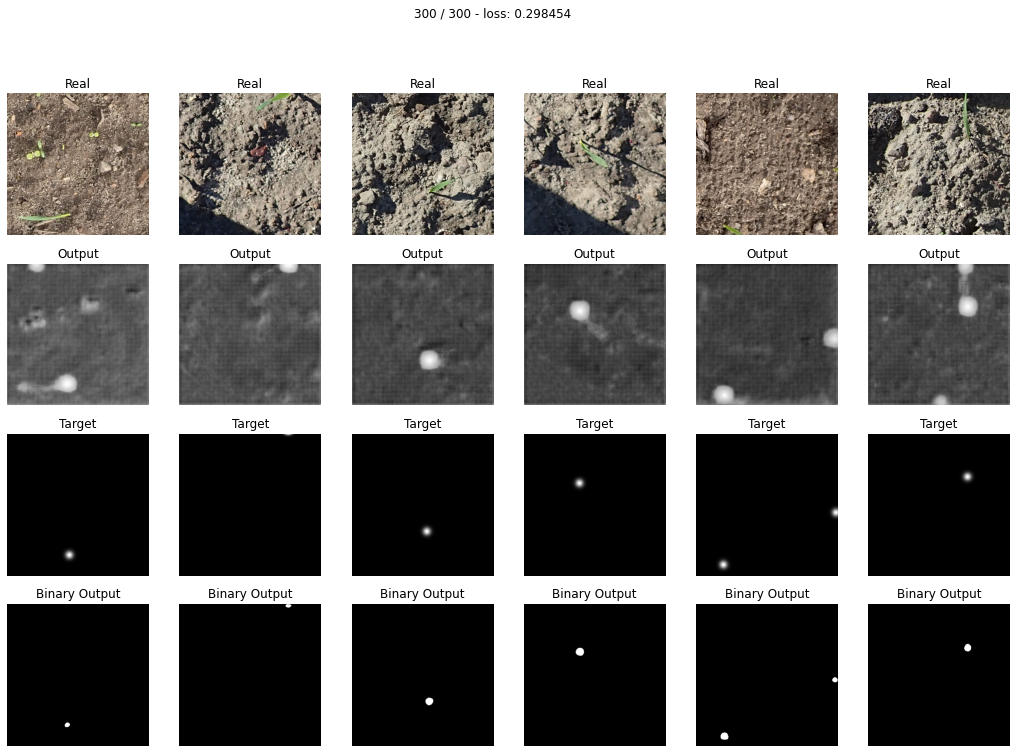

In [ ]:
import torch.optim as optim

max_epochs = 300
optim = torch.optim.AdamW(model.parameters())
train_losses, test_losses = train(model, optim, dice_loss, max_epochs, data_tr)

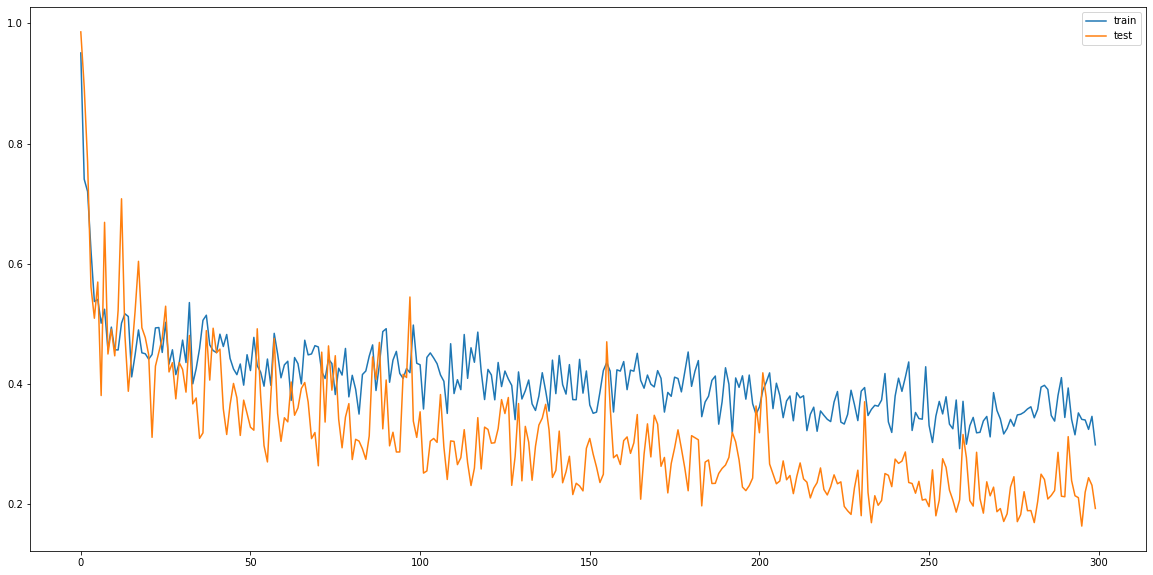

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.show()

In [ ]:
from numpy import asarray
from numpy import savetxt
data = asarray(train_losses)
savetxt('/content/drive/MyDrive/Bachelor/train_losses18_20.csv', data, delimiter=',')

In [ ]:
from numpy import asarray
from numpy import savetxt
data = asarray(test_losses)
savetxt('/content/drive/MyDrive/Bachelor/val_losses18_20.csv', data, delimiter=',')